# libs

In [28]:
import os
import pprint
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import pickle
import chess
import chess.pgn
import chess.svg

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

from IPython.display import Image, SVG, display

# carrega exemplo

In [29]:
pgn  = open("arquivos/lichess_pgn_2019.11.20_naosoudoramo_vs_Cartoni.IZbcH0eO.pgn")
game = chess.pgn.read_game(pgn)

     1. d4   True
    1...c6  False
    2. Bf4   True
    2...d5  False
     3. e3   True
   3...Bf5  False
    4. Bd3   True
  4...Bxd3  False
   5. Qxd3   True
   5...Nf6  False
     6. f3   True
    6...e6  False
     7. c3   True
    7...h6  False
     8. g4   True
   8...Bd6  False
     9. h4   True
  9...Bxf4  False
  10. exf4   True
  10...O-O  False
    11. g5   True
 11...hxg5  False
  12. hxg5   True
  12...Ne4  False
  13. fxe4   True
  13...Re8  False
    14. e5   True
  14...Kf8  False
  15. Rh8+   True
  15...Ke7  False
 16. Rxe8+   True
 16...Qxe8  False
   17. Nd2   True
  17...Qh8  False
 18. O-O-O   True
  18...Nd7  False
    19. f5   True
 19...exf5  False
  20. Qxf5   True
   20...g6  False
   21. Qf4   True
  21...Rf8  False
   22. Rf1   True
  22...Qg7  False
   23. Nb3   True
  23...Nb8  False
   24. Re1   True
  24...Ke6  False
  25. Nc5+   True
  25...Ke7  False
    26. e6   True
   26...f6  False
 27. gxf6+   True
 27...Qxf6  False
  28. Qc7+   True
  28...Ke8

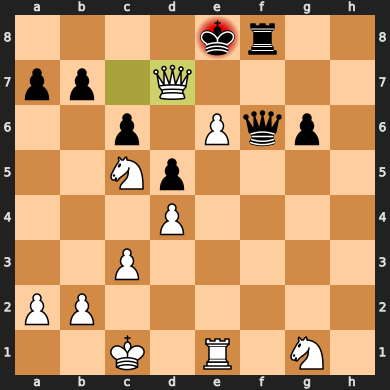

In [30]:
board = game.board()
for m in game.mainline_moves():
    print('{:>10} {:>6}'.format( board.variation_san([m]), str(board.turn)))
    board.push(m)
board

# tratamento

## constantes

In [31]:
PESO_P = 15
PESO_R = 75
PESO_N = 45
PESO_B = 45
PESO_Q = 100
PESO_K = 150

PESOS = {
'PESO_P' : PESO_P,
'PESO_R' : PESO_R,
'PESO_N' : PESO_N,
'PESO_B' : PESO_B,
'PESO_Q' : PESO_Q,
'PESO_K' : PESO_K    
}

## funcoes

In [80]:
class Representacao:
    def __init__(self, partida, pesos):
        self.matriz   = list()
        self.match    = partida
        self.pesos    = pesos
        self.dicpesos = {'p':-self.pesos['PESO_P'], 'r':-self.pesos['PESO_R'], 
                         'n':-self.pesos['PESO_N'], 'b':-self.pesos['PESO_B'], 
                         'q':-self.pesos['PESO_Q'], 'k':-self.pesos['PESO_K'],
                         '.':0,
                         'K':self.pesos['PESO_K'], 'Q':self.pesos['PESO_Q'], 
                         'B':self.pesos['PESO_B'], 'N':self.pesos['PESO_N'], 
                         'R':self.pesos['PESO_R'], 'P':self.pesos['PESO_P']}

        self.tuppesos = {-self.pesos['PESO_P']:(chess.PAWN, chess.BLACK),   -self.pesos['PESO_R']:(chess.ROOK, chess.BLACK), 
                         -self.pesos['PESO_N']:(chess.KNIGHT, chess.BLACK), -self.pesos['PESO_B']:(chess.BISHOP, chess.BLACK), 
                         -self.pesos['PESO_Q']:(chess.QUEEN, chess.BLACK),  -self.pesos['PESO_K']:(chess.KING, chess.BLACK),
                         0:'.',
                         self.pesos['PESO_K']:(chess.KING, chess.WHITE),   self.pesos['PESO_Q']:(chess.QUEEN, chess.WHITE), 
                         self.pesos['PESO_B']:(chess.BISHOP, chess.WHITE), self.pesos['PESO_N']:(chess.KNIGHT, chess.WHITE),
                         self.pesos['PESO_R']:(chess.ROOK, chess.WHITE),   self.pesos['PESO_P']:(chess.PAWN, chess.WHITE)}
    
    
    def symbol2value(self, symbol):
        for i, v in enumerate(symbol):
            if v in self.dicpesos:
                symbol[i] = self.dicpesos[v]
        return symbol
    
    
    def savefig(self, fname):
        turn_count = 0
        board = self.match.board()
        
        if not os.path.exists(rf"./{fname}"):
            os.makedirs(rf"./{fname}")
        
        for m in self.match.mainline_moves():
            with open(rf'./{fname}/chess_{str(turn_count).zfill(3)}.svg', 'w') as img:
                img.write(chess.svg.board(board=board))
            board.push(m)
            turn_count += 1
        with open(rf'./{fname}/chess_{str(turn_count).zfill(3)}.svg', 'w') as img:
                img.write(chess.svg.board(board=board))
    
    
    def get_matriz(self):
        if len(self.matriz)==0:
            turn_color = lambda s: 'W' if s == True else 'B'
            turn_count = 0

            board = self.match.board()
            meta  = dict(self.match.headers)
            w_id = '{}'.format( meta['White'].split(',')[0].lower().replace(' ', '_') )
            b_id = '{}'.format( meta['Black'].split(',')[0].lower().replace(' ', '_') )

            players = { 'W' : w_id, 'B': b_id }

            for m in self.match.mainline_moves():
                state  = [ str(board.piece_at(i)) if board.piece_at(i) != None else '.' for i in range(64) ]
                target = [ str(board.piece_at(m.from_square)), m.from_square, m.to_square ]
                _num_state   = self.symbol2value(state)
                _num_target  = self.symbol2value(target)
                _num_move    = {'moved_piece': _num_target[0],
                                'moved_from' : _num_target[1],
                                'moved_to'   : _num_target[2]}
                self.matriz.append( { 'player'          : players[turn_color(board.turn)],
                                 'full_move_count' : board.fullmove_number,
                                 'turn_count'      : str(turn_count).zfill(3),
                                 'turn_color'      : turn_color(board.turn),
                                 'state'           : _num_state,
                                 'is_checkmate'    : board.is_checkmate(), 
                                 'is_stalemate'    : board.is_stalemate(),
                                 'is_castling'     : board.is_castling(m), 
                                 'has_castling'    : board.has_castling_rights(board.turn),
                                 'move'            : _num_move } )
                board.push(m)
                turn_count += 1
            state  = [str(board.piece_at(i)) if board.piece_at(i) != None else '.' for i in range(64) ]
            target = [ str(board.piece_at(m.from_square)), m.from_square, m.to_square ]
            _num_state   = self.symbol2value(state)
            _num_target  = self.symbol2value(target)
            _num_move    = {'moved_piece': _num_target[0],
                            'moved_from' : _num_target[1],
                            'moved_to'   : _num_target[2]}
            self.matriz.append( { 'player'          : players[turn_color(board.turn)],
                             'full_move_count' : board.fullmove_number,
                             'turn_count'      : str(turn_count).zfill(3),
                             'turn_color'      : turn_color(board.turn),
                             'state'           : _num_state,
                             'is_checkmate'    : board.is_checkmate(), 
                             'is_stalemate'    : board.is_stalemate(),
                             'is_castling'     : board.is_castling(m), 
                             'has_castling'    : board.has_castling_rights(board.turn),
                             'move'            : _num_move } )
            return self.matriz
        return self.matriz
    
    
    def get_dataframe(self):
        matriz = self.get_matriz()
        dataframe = pd.DataFrame(matriz)
        dataframe = pd.concat([dataframe.drop(columns=['move']), pd.DataFrame(list(dataframe['move']))], axis=1)
        return dataframe

In [374]:
class Operacao:
    def __init__(self, pesos):
        self.scaler = MinMaxScaler()
        self.pesos_abs = np.array(list(PESOS.values())+[0]).reshape(-1, 1)
        self.pesos_prc = np.round( self.scaler.fit_transform(self.pesos_abs), 4)
        
        self.pesos_abs = self.pesos_abs.reshape(1,-1)[0]
        self.pesos_prc = self.pesos_prc.reshape(1,-1)[0]

        self.pesos_abs = np.append(self.pesos_abs, (-1)*self.pesos_abs)
        self.pesos_prc = np.append(self.pesos_prc, (-1)*self.pesos_prc)
        
        self.map_p    = {k:v for k,v in zip(self.pesos_abs, self.pesos_prc)}
        
        lista = np.array([i for i in range(64)])
        mat = lista.reshape(8,8)
        mat_b = np.flip(mat_default, 1)
        mat_w = np.flip(mat_default, 0)
        self.pov_w_move = dict()
        self.pov_b_move = dict()

        for i in lista:
            self.pov_b_move[i] = [np.where(mat_b == i)[0][0], np.where(mat_b == i)[1][0]]
            self.pov_w_move[i] = [np.where(mat_w == i)[0][0], np.where(mat_w == i)[1][0]]

    def estado8x8(self, estado, referencial):
        if referencial == "B":
            return np.flip(np.array(estado['state']).reshape(8,8), 1)
        else:
            return np.flip(np.array(estado['state']).reshape(8,8), 0)
    
    def estado8x8_minmax(self, estado):
        return np.vectorize(self.map_p.get)(estado)
    
    def deltavec(self, u, v):
        return [v[0]-u[0], v[1]-u[1]]

- - -

In [81]:
partida = Representacao(game, PESOS)

In [82]:
partida.savefig("teste")

In [83]:
pprint.pprint(partida.get_matriz()[13], compact=True)

{'full_move_count': 7,
 'has_castling': True,
 'is_castling': False,
 'is_checkmate': False,
 'is_stalemate': False,
 'move': {'moved_from': 55, 'moved_piece': -15, 'moved_to': 47},
 'player': 'cartoni',
 'state': [75, 45, 0, 0, 150, 0, 45, 75, 15, 15, 0, 0, 0, 0, 15, 15, 0, 0, 15,
           100, 15, 15, 0, 0, 0, 0, 0, 15, 0, 45, 0, 0, 0, 0, 0, -15, 0, 0, 0,
           0, 0, 0, -15, 0, -15, -45, 0, 0, -15, -15, 0, 0, 0, -15, -15, -15,
           -75, -45, 0, -100, -150, -45, 0, -75],
 'turn_color': 'B',
 'turn_count': '013'}


In [84]:
partida.get_dataframe().head(3)

,player,full_move_count,turn_count,turn_color,state,is_checkmate,is_stalemate,is_castling,has_castling,moved_piece,moved_from,moved_to
0,naosoudoramo,1,000,W,"[75, 45, 45, 100, 150, 45, 45, 75, 15, 15, 15,...",False,False,False,True,15,11,27
1,cartoni,1,001,B,"[75, 45, 45, 100, 150, 45, 45, 75, 15, 15, 15,...",False,False,False,True,-15,50,42
2,naosoudoramo,2,002,W,"[75, 45, 45, 100, 150, 45, 45, 75, 15, 15, 15,...",False,False,False,True,45,2,29


<br/>

In [360]:
op = Operacao(PESOS)

In [361]:
df = partida.get_dataframe()

In [362]:
df['pov_w_board'] = df.apply(lambda r: op.estado8x8(r, "W"), axis=1)
df['pov_w_board_minmax'] = df.apply(lambda r: op.estado8x8_minmax(r['pov_w_board']), axis=1)

In [363]:
df['pov_w_from'] = df['moved_from'].map(op.pov_w_move).apply(lambda x: x[::-1])
df['pov_w_to'] = df['moved_to'].map(op.pov_w_move).apply(lambda x: x[::-1])
df['pov_w_delta'] = df.apply(lambda r: op.deltavec(r['pov_w_from'], r['pov_w_to']), axis=1)

,player,full_move_count,turn_count,turn_color,state,is_checkmate,is_stalemate,is_castling,has_castling,moved_piece,moved_from,moved_to,pov_w_board,pov_w_board_minmax,pov_w_from,pov_w_to,pov_w_delta
13,cartoni,7,013,B,"[75, 45, 0, 0, 150, 0, 45, 75, 15, 15, 0, 0, 0...",False,False,False,True,-15,55,47,"[[-75, -45, 0, -100, -150, -45, 0, -75], [-15,...","[[-0.5, -0.3, -0.0, -0.6667, -1.0, -0.3, -0.0,...","[7, 1]","[7, 2]","[0, 1]"


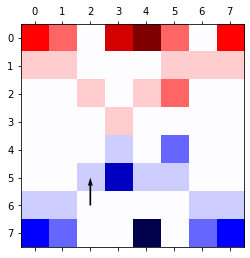

In [371]:
index = 13
display(df.iloc[[index], :])
plt.matshow(df['pov_w_board_minmax'][index], cmap='seismic_r');
plt.quiver([df['pov_w_from'][index-1][0]], [df['pov_w_from'][index-1][1]], [df['pov_w_delta'][index-1][0]], [df['pov_w_delta'][index-1][1]], angles='xy', scale_units='xy', scale=1)
plt.show()

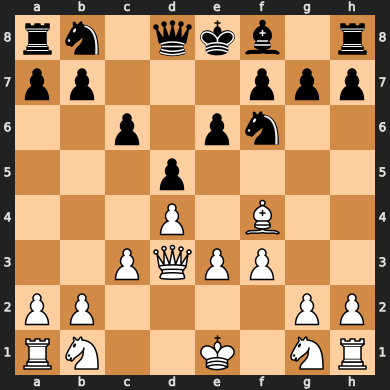

In [373]:
display(SVG(filename=rf'teste/chess_{str(index).zfill(3)}.svg'))

.